# Predictive Modeling

For the last part of this take home challenge my goal is to create a model that can correctly classify riders that are retained (that is who took a trip in the last 30 days). This will involve cleaning, EDA and building the model followed by interpreting the results of the best performing model

### Data Wrangling

In [1]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Here I can see that 3 columns have nulls. While avg_rating_by_driver and phone only have a few hundred, avg_rating_of_driver is missing several thousand. For now I will leave all of these alone until I see if they need to be filled and how to best do that after finishing cleaning and beginning EDA

First I want to see how many riders are retained and create a column for that in the data so it can be analyzed and eventually incorporated into the model

In [5]:
# Convert data columns into datetime objects
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [6]:
# Confirm change
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Now that those columns are properly formatted I will find the most recent trip date and use that to determine our retention ratio and create a row based on whether a rider is retained or not

In [7]:
df['last_trip_date'].describe(datetime_is_numeric = True)

count                            50000
mean     2014-04-19 08:02:04.992000256
min                2014-01-01 00:00:00
25%                2014-02-14 00:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

The last trip was on July 1st at midnight. Since June has 30 days that means retained drivers needed to take a trip during that month. Next I'll compute that ratio

In [8]:
fraction_retained = (df.last_trip_date >= '2014-06-01').sum() / (df.last_trip_date >= '2014-06-01').count()
fraction_retained

0.37608

So about 37.6% of riders were retained. Next I'll make the new column

In [9]:
# Create new column
df['retained'] = (df.last_trip_date >= '2014-06-01')*1

In [10]:
# Confirm new column
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [11]:
# Describe() data
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


While I still have null values there isn't a clear need or way to handle them yet. I'll continue on to EDA and revisit this later

### EDA

To start EDA I'll take a look at the correlation heatmap to see which columns are most correlated with the new retained column

<AxesSubplot:>

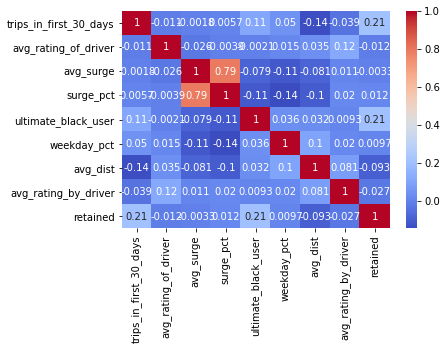

In [12]:
# Create correlation heatmap

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Hmm, looks like there aren't a lot of strong correlations with the retained column. The top 2 variables are trips_in_first_30_days and ultimate_black_user which are both around 0.21. Next I'll take a look at the categorical variables to see if there is any better correlation there

In [13]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [14]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Starting with the 2 non date columns I can see that there aren't too many unique values there. This is good because it means that dummy variables will work well. However, before I do that I will need to fill in the null values in phone

In [15]:
df.phone.fillna('Other', inplace=True)
df.phone.value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

Replacing with 'Other' makes the most sense since I can't be sure what phone they used. Since Other makes up a small percentage of the data this shouldn't affect my model in a significant way

In [16]:
# Create dummy variables
dummy_c = pd.get_dummies(df['city'])
dummy_p = pd.get_dummies(df['phone'])

In [17]:
# Add dummies
df = pd.concat([df, dummy_c], axis = 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,0,1,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,1,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,0,1,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0,0,1


In [18]:
# Add dummies
df = pd.concat([df, dummy_p], axis = 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [19]:
# Drop categorical columns
df.drop(['city', 'phone'], axis=1, inplace=True)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [20]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Looking at the new dummy columns I can see that 33% are from Astapor, 20 from King's Landing and the remaining 46+% are from Winterfell. The phone spread is about 70% iPhone and 30% Android with Other making up less than 1%

Now I'll look at the correlation heatmap again with the new columns

<AxesSubplot:>

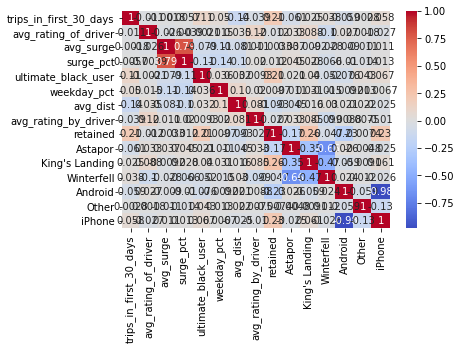

In [21]:
# Recreate correlation heatmap

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Hmm, unfortunately there are so many variables that this isn't readable. I'll look at the individual values instead

In [22]:
# Create correlation dataframe
correlation_df = df.corr()
correlation_df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039115,0.210463,-0.061075,0.024650,0.037735,-0.059309,0.002786,0.058342
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.003899,-0.002086,0.014630,0.034509,0.123175,-0.011653,0.032699,0.088392,-0.103100,0.026729,0.001758,-0.026864
avg_surge,-0.001841,-0.026189,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010597,-0.003333,0.037172,-0.009198,-0.027643,-0.008977,-0.011423,0.011104
surge_pct,0.005720,-0.003899,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.020103,0.011797,0.045457,0.028221,-0.065603,-0.010150,-0.014456,0.012851
ultimate_black_user,0.112210,-0.002086,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009343,0.205002,0.021259,0.039649,-0.051990,-0.075836,0.043145,0.067002
weekday_pct,0.050388,0.014630,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020442,0.009693,-0.010540,0.031349,-0.015318,-0.009241,0.012753,0.006726
avg_dist,-0.136329,0.034509,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.080540,-0.092780,-0.045431,0.015877,0.030050,0.020888,0.022372,-0.025030
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.020103,0.009343,0.020442,0.080540,1.000000,-0.026791,0.032580,0.084648,-0.098929,0.008783,0.007461,-0.010148
retained,0.210463,-0.011653,-0.003333,0.011797,0.205002,0.009693,-0.092780,-0.026791,1.000000,-0.174655,0.262284,-0.046611,-0.225464,-0.007419,0.225244
Astapor,-0.061075,0.032699,0.037172,0.045457,0.021259,-0.010540,-0.045431,0.032580,-0.174655,1.000000,-0.354298,-0.657563,0.025642,-0.004772,-0.024539


In [23]:
# View retained column
correlation_df['retained'].sort_values(ascending = False)

retained                  1.000000
King's Landing            0.262284
iPhone                    0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
Other                    -0.007419
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
Winterfell               -0.046611
avg_dist                 -0.092780
Astapor                  -0.174655
Android                  -0.225464
Name: retained, dtype: float64

Looks like from the new columns King's Landing and iPhone were positively correlated while Astapor and Android had a negative correlation. Winterfell and Other were both weakly correlated and overall there still isn't a strong correlation with any column

Lastly I'll look at the date columns. To compare these I'll look at the dates as a number by subtracting the first date in the data from each date in the dataframe

In [24]:
df.signup_date.describe(datetime_is_numeric = True)

count                         50000
mean     2014-01-16 13:04:20.352000
min             2014-01-01 00:00:00
25%             2014-01-09 00:00:00
50%             2014-01-17 00:00:00
75%             2014-01-24 00:00:00
max             2014-01-31 00:00:00
Name: signup_date, dtype: object

In [25]:
df.last_trip_date.describe(datetime_is_numeric = True)

count                            50000
mean     2014-04-19 08:02:04.992000256
min                2014-01-01 00:00:00
25%                2014-02-14 00:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

The minimum value for both rows is January 1st at midnight so this is the date I'll subtract from each date to transform the columns into a numerical value

In [26]:
# Transform signup_date to int and subtract the start date minus 1
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [27]:
# Transform last_trip_date by subtracting the minimum trip date and adding 1 to ensure it is this year
ref = min(df['last_trip_date'])
df['last_trip_date'] = (df['last_trip_date'] - ref).dt.days + 1

In [28]:
# Confirm rows were changed
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,4,25,4.7,1.10,168,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,29,5.0,1.00,125,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,6,4.3,1.00,7,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,10,4.6,1.14,180,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,27,4.4,1.19,74,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [29]:
df['signup_date'].corr(df['retained'])

-0.02021061843484832

In [30]:
df['last_trip_date'].corr(df['retained'])

0.7808374961937277

While signup_date had a very small correlation last_trip_date had a very high value. This makes sense because retained was based off of this column

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int32  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   last_trip_date          50000 non-null  int64  
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  retained                50000 non-null  int32  
 11  Astapor                 50000 non-null  uint8  
 12  King's Landing          50000 non-null  uint8  
 13  Winterfell              50000 non-null  uint8  
 14  Android                 50000 non-null

Before modeling I need to fill in the missing values in the avg_rating columns. I'll use the mean to fill these in so that the distribution isn't skewed

In [32]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

Lastly I need to make ultimate_black_user an int so I can better analyze it and so it will work with the model

In [33]:
df['ultimate_black_user'] = df['ultimate_black_user']*1

In [34]:
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,16.54468,4.601559,1.074764,109.334780,8.849536,0.37708,60.926084,5.796827,4.778158,0.376080,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,3.792684,8.75422,0.564977,0.222336,61.718985,19.958811,0.48466,37.081503,5.707357,0.445753,0.484405,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.00000,4.500000,1.000000,45.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,17.00000,4.700000,1.000000,128.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,24.00000,5.000000,1.050000,169.000000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,125.000000,31.00000,5.000000,8.000000,182.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


With all that done all that's left is to proceed to modeling

### Modeling

First I will set up my variables for the models and then train test split the data

In [35]:
# Set up X and y variables
X = df.drop(['retained', 'last_trip_date'], axis = 1)
y = df['retained']

last_trip_date must be dropped because retained was made using it so a model could have 100% success but not actually make any insights

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [37]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
X_scaled = scaler.transform(X)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 123)

Now that everything is prepared its time to jump into models starting with logistic regression

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Set up model
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[7956 1348]
 [2906 2790]]


In [42]:
#from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer

# Define scorer
def false_total(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    false_p = matrix[0,1]
    false_n = matrix[1,0]
    if ((false_p < 202) & (false_n < 2000)):
        falses = (false_p+false_n)/sum(sum(matrix))
        return falses
    else:
        falses = 1
        return falses

# Make scorer
scorer = make_scorer(false_total, greater_is_better=False)

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10), 'max_depth':range(2,7), 'min_samples_split':range(100,1000,200)}
model = RandomForestClassifier(random_state=123)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters:")
print(clf.best_params_, '\n')
print("Grid scores:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Classification report:")
y_true, y_pred = y_test, clf.predict(X_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters:
{'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 20} 

Grid scores:
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 20}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 30}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 40}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 50}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 60}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 70}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 80}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 90}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 20}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 30}
-1.000 (+/-0.000) for {'max_depth': 2, 'min_samples_spl

In [44]:
from sklearn.ensemble import AdaBoostClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10)}
model = AdaBoostClassifier(random_state=123)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters:")
print(clf.best_params_, '\n')
print("Grid scores:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Classification report:")
y_true, y_pred = y_test, clf.predict(X_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters:
{'n_estimators': 20} 

Grid scores:
-1.000 (+/-0.000) for {'n_estimators': 20}
-1.000 (+/-0.000) for {'n_estimators': 30}
-1.000 (+/-0.000) for {'n_estimators': 40}
-1.000 (+/-0.000) for {'n_estimators': 50}
-1.000 (+/-0.000) for {'n_estimators': 60}
-1.000 (+/-0.000) for {'n_estimators': 70}
-1.000 (+/-0.000) for {'n_estimators': 80}
-1.000 (+/-0.000) for {'n_estimators': 90}

Classification report:
[[7961 1343]
 [1975 3721]] 



Since the purpose of this is to see how to retain members I am most interested in minimizing false positives. Therefore, between these models the best choice would be random forest. Now I will look at the feature importances of that model

In [45]:
# Recreate the best RF Model
model = RandomForestClassifier(max_depth=2, min_samples_split=100, n_estimators=20, random_state=123)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)

# List importance of features
pd.DataFrame(model.feature_importances_, 
             index = X.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
surge_pct,0.206183
avg_surge,0.200276
avg_rating_by_driver,0.135035
King's Landing,0.104622
weekday_pct,0.080181
trips_in_first_30_days,0.079880
Android,0.073092
ultimate_black_user,0.040100
Astapor,0.039790
Winterfell,0.027968


From this the top 3 important features are Surge(twice), Average Rating by Driver and being in King's Landing. Based on this Ultimate should focus on riders whose usage changes during surges. They should ensure that those drivers are marketed to more. For average rating by driver it seems that bad riders don't seem to be retained. This is a tricky one to figure out but perhaps a viable strategy would be to incentivize riders to be kind by offering discounts for consistently high ratings. Lastly for King's Landing the best strategy is to market more to these riders